# 📈 Cryptocurrency Portfolio Optimization using Markowitz Mean-Variance Framework

## Project Overview

This project implements a **dynamic portfolio optimization strategy** for cryptocurrency assets using the classical Markowitz Mean-Variance framework with rolling windows.

### Dataset
- **Assets**: 20 cryptocurrency signals
- **Time horizon**: ~2 years of daily data

### Constraints
| Constraint | Threshold |
|------------|----------|
| Position type | Long-only (no negative weights) |
| Portfolio volatility | < 25%  |
| Diversification (concentration) | > 70% |
| Transaction fees | < 0.5% of initial capital |

### Objective
**Maximize the portfolio's Sharpe Ratio** - the risk-adjusted return measure that quantifies excess return per unit of risk.

---

## Table of Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Efficient Frontier Analysis](#2-efficient-frontier-analysis)
3. [Rolling Window Optimization](#3-rolling-window-optimization)
4. [Performance Metrics](#4-performance-metrics)
5. [Benchmark Comparison](#5-benchmark-comparison)
6. [Hyperparameter Tuning](#6-hyperparameter-tuning)

---

## 1. Setup & Data Loading

In [18]:
"""
=============================================================================
LIBRARY IMPORTS
=============================================================================
Required packages:
- numpy: Numerical computations and matrix operations
- pandas: Data manipulation and time series handling
- scipy.sparse: Sparse matrix operations (used by cvxpy internally)
- cvxpy: Convex optimization solver for portfolio optimization
- matplotlib: Visualization and plotting
=============================================================================
"""

import numpy as np
import pandas as pd
import scipy.sparse as sp
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

# Suppress warnings for cleaner output (use with caution in production)
warnings.filterwarnings("ignore")

print('✅ Setup complete')

✅ Setup complete


In [19]:
"""
=============================================================================
DATA LOADING & PREPROCESSING
=============================================================================
Load cryptocurrency price data and compute daily returns.

The pct_change() function computes: r_t = (P_t - P_{t-1}) / P_{t-1}
where P_t is the price at time t.

We drop the first row (NaN) since there's no previous day to compute return.
=============================================================================
"""

# Load price data from CSV (assumes date column as index)
df = pd.read_csv("data.csv", index_col=0)

# Compute simple daily returns: (P_t - P_{t-1}) / P_{t-1}
returns = df.pct_change().dropna()

print(f"📊 Dataset shape: {returns.shape}")
print(f"📅 Date range: {returns.index[0]} to {returns.index[-1]}")
print(f"💰 Number of assets: {returns.shape[1]}")

📊 Dataset shape: (1094, 20)
📅 Date range: 2021-03-29 to 2024-03-26
💰 Number of assets: 20


## 2. Efficient Frontier Analysis

The **Efficient Frontier** represents the set of optimal portfolios that offer the highest expected return for a given level of risk. We use this to find the optimal risk aversion parameter (γ) that maximizes the Sharpe Ratio.

In [20]:
"""
=============================================================================
MARKOWITZ OPTIMIZATION SETUP
=============================================================================
The Markowitz Mean-Variance optimization problem:

    minimize    (1/2) * w' Σ w  -  γ * μ' w
    subject to  Σ w_i = 1       (fully invested)
                w_i ≥ 0         (long-only constraint)

Where:
- w: Portfolio weights vector (n x 1)
- μ: Expected returns vector (n x 1), annualized
- Σ: Covariance matrix (n x n), annualized
- γ: Risk aversion parameter (higher = more aggressive)

Note: We multiply daily statistics by 365 (trading days) to annualize.
=============================================================================
"""

# Number of assets in the portfolio
n = 20

# Calculate annualized expected returns (mean daily return × 365)
# μ = E[r] × 365
mu = returns.mean().values.T * 365

# Calculate annualized covariance matrix
# Σ_annual = Σ_daily × 365 (variance scales linearly with time for i.i.d. returns)
Sigma = returns.cov().values * 365

# Define optimization variables
w = cp.Variable(n)                    # Portfolio weights
gamma = cp.Parameter(nonneg=True)     # Risk aversion parameter (to be varied)

# Define portfolio metrics
ret = mu.T @ w                        # Expected portfolio return: μ' w
risk = cp.quad_form(w, Sigma)         # Portfolio variance: w' Σ w

# Formulate the optimization problem
# Objective: minimize (1/2) * risk - γ * return (equivalent to maximizing risk-adjusted return)
objective = cp.Minimize(0.5 * risk - gamma * ret)

# Constraints:
constraints = [
    cp.sum(w) == 1.0,  # Fully invested (weights sum to 1)
    w >= 0             # Long-only (no short selling)
]

prob = cp.Problem(objective, constraints)

print("✅ Optimization problem formulated")

✅ Optimization problem formulated


In [21]:
"""
=============================================================================
EFFICIENT FRONTIER COMPUTATION
=============================================================================
Trace out the efficient frontier by solving the optimization problem
for different values of the risk aversion parameter γ.

- Low γ: Conservative portfolio (minimize risk)
- High γ: Aggressive portfolio (maximize return)

We use logarithmically spaced values to better capture the frontier shape.
=============================================================================
"""

# Number of points to compute on the efficient frontier
SAMPLES = 200

# Initialize arrays to store results
risk_data = np.zeros(SAMPLES)   # Portfolio standard deviation (volatility)
ret_data = np.zeros(SAMPLES)    # Portfolio expected return

# Create logarithmically spaced gamma values from 10^-4 to 10^1
# This covers a wide range from very conservative to very aggressive
gamma_vals = np.logspace(-4, 1, num=SAMPLES)

# Solve optimization for each gamma value
for i in range(SAMPLES):
    gamma.value = gamma_vals[i]
    prob.solve()
    
    # Store portfolio volatility (standard deviation = sqrt(variance))
    risk_data[i] = cp.sqrt(risk).value
    
    # Store portfolio expected return
    ret_data[i] = ret.value

print(f"✅ Computed {SAMPLES} points on the efficient frontier")

✅ Computed 200 points on the efficient frontier


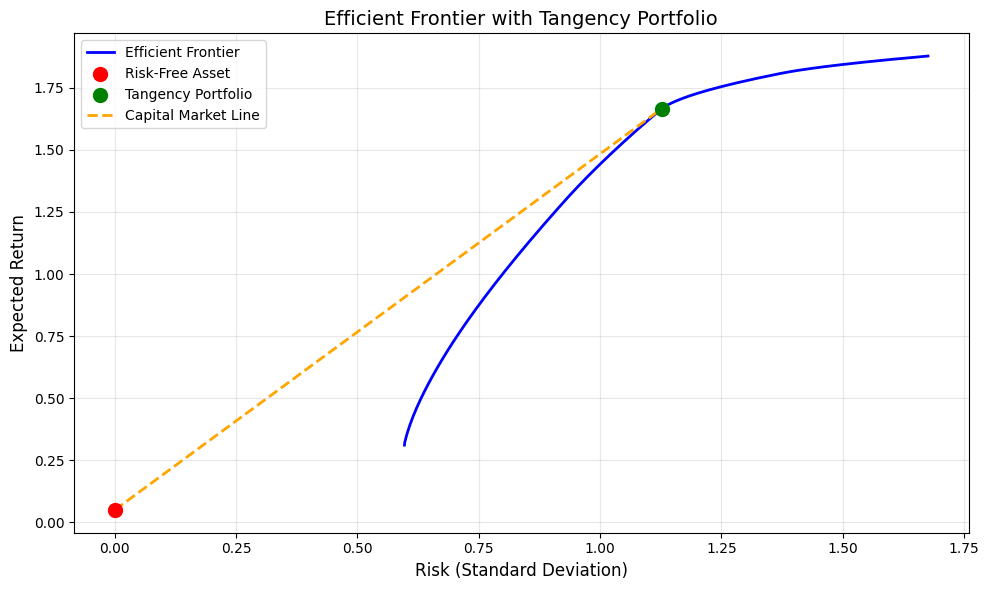


🎯 Optimal Risk Aversion (γ): 0.7843
📈 Tangency Portfolio Return: 166.54%
📉 Tangency Portfolio Volatility: 112.67%
⭐ Maximum Sharpe Ratio: 1.43


In [22]:
"""
=============================================================================
TANGENCY PORTFOLIO & OPTIMAL GAMMA
=============================================================================
The tangency portfolio is the point on the efficient frontier where the
Capital Market Line (CML) from the risk-free rate is tangent to the frontier.

This portfolio maximizes the Sharpe Ratio:
    SR = (E[R_p] - R_f) / σ_p

Where:
- E[R_p]: Expected portfolio return
- R_f: Risk-free rate (assumed 5% annually)
- σ_p: Portfolio standard deviation
=============================================================================
"""

# Risk-free rate (annualized)
RISK_FREE_RATE = 0.05

# Calculate Sharpe Ratio for each point on the frontier
SR = (ret_data - RISK_FREE_RATE) / risk_data

# Find the portfolio with maximum Sharpe Ratio (tangency portfolio)
max_SR_idx = np.argmax(SR)

# Extract optimal parameters
gamma_optimal = gamma_vals[max_SR_idx]     # Optimal risk aversion
sigma_star = risk_data[max_SR_idx]         # Optimal portfolio volatility
ret_star = ret_data[max_SR_idx]            # Optimal portfolio return

# Capital Market Line (CML): connects risk-free asset to tangency portfolio
x_tan = [0, sigma_star]
y_tan = [RISK_FREE_RATE, ret_star]

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(risk_data, ret_data, color="blue", linewidth=2, label='Efficient Frontier')
plt.scatter([0], [RISK_FREE_RATE], color="red", s=100, zorder=5, label='Risk-Free Asset')
plt.scatter([sigma_star], [ret_star], color="green", s=100, zorder=5, label='Tangency Portfolio')
plt.plot(x_tan, y_tan, '--', color='orange', linewidth=2, label='Capital Market Line')

plt.xlabel("Risk (Standard Deviation)", fontsize=12)
plt.ylabel("Expected Return", fontsize=12)
plt.title("Efficient Frontier with Tangency Portfolio", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n🎯 Optimal Risk Aversion (γ): {gamma_optimal:.4f}")
print(f"📈 Tangency Portfolio Return: {ret_star:.2%}")
print(f"📉 Tangency Portfolio Volatility: {sigma_star:.2%}")
print(f"⭐ Maximum Sharpe Ratio: {SR[max_SR_idx]:.2f}")

## 3. Rolling Window Optimization

Instead of a static one-time optimization, we implement a **dynamic strategy** using rolling windows:

- **In-Sample (IS) Window**: Historical data used to estimate parameters (μ, Σ)
- **Out-of-Sample (OOS) Window**: Future period where we apply the optimized weights

This approach adapts to changing market conditions and provides more realistic backtesting results.

In [23]:
"""
=============================================================================
ROLLING WINDOW PARAMETERS
=============================================================================
Define the parameters for the rolling window optimization strategy.

Key parameters:
- IS_window: Number of days for parameter estimation (lookback period)
- OOS_window: Number of days before rebalancing (holding period)
- gamma: Risk aversion parameter from efficient frontier analysis
=============================================================================
"""

# Optimal window sizes (found through hyperparameter tuning)
IS_window = 70    # In-sample window: 70 days of historical data
OOS_window = 35   # Out-of-sample window: rebalance every 35 days

# Risk aversion parameter (slightly adjusted from optimal for robustness)
gamma = 1.7

# Number of assets
n_assets = returns.shape[1]

# Storage lists for results
w_list = []         # Portfolio weights at each rebalancing
date_list = []      # Rebalancing dates
volatility_t = []   # Portfolio volatility at each period
ret_t = []          # Daily returns of the portfolio

# Date index for reference
dates = returns.index

print(f"📊 Configuration:")
print(f"   - In-Sample Window: {IS_window} days")
print(f"   - Out-of-Sample Window: {OOS_window} days")
print(f"   - Risk Aversion (γ): {gamma}")

📊 Configuration:
   - In-Sample Window: 70 days
   - Out-of-Sample Window: 35 days
   - Risk Aversion (γ): 1.7


In [24]:
"""
=============================================================================
HELPER FUNCTION: CAPM Expected Return
=============================================================================
Calculate expected return using the Capital Asset Pricing Model (CAPM).

Formula: E[R_i] = R_f + β_i × (E[R_m] - R_f)

Where:
- R_f: Risk-free rate
- β_i: Asset beta (sensitivity to market)
- E[R_m]: Expected market return

Note: This function is available as an alternative estimation method.
=============================================================================
"""

def calculate_capm(risk_free_rate, beta, market_return):
    """
    Calculate expected returns using CAPM.
    
    Parameters:
    -----------
    risk_free_rate : float
        Risk-free rate of return
    beta : float
        Asset's sensitivity to market movements
    market_return : np.array
        Historical market returns
    
    Returns:
    --------
    np.array
        CAPM-based expected returns for each asset
    """
    risk_free_rate = risk_free_rate * np.ones(market_return.shape)
    return risk_free_rate + beta * (market_return - risk_free_rate)

In [25]:
"""
=============================================================================
ROLLING WINDOW OPTIMIZATION LOOP
=============================================================================
Main optimization loop that:
1. Extracts in-sample data for parameter estimation
2. Estimates expected returns using Exponential Weighted Moving Average (EWMA)
3. Solves the Markowitz optimization problem
4. Applies diversification and volatility constraints
5. Records out-of-sample performance

The loop starts at day 278 (to have enough history) and ends 86 days before
the end (to have OOS data for evaluation).
=============================================================================
"""

# EWMA span parameter for return estimation
# Lower span = more responsive to recent returns, higher span = smoother estimates
EWMA_SPAN = 3

# Daily risk-free rate (5% annual rate / 365 days)
DAILY_RF_RATE = 0.05 / 365

# Maximum allowed portfolio volatility (23.5% to stay under 25% with buffer)
MAX_VOLATILITY = 0.235

# Diversification parameter: minimum weight addition for concentration constraint
W_DIV = 0.035

for t in range(278, len(returns) - 86, OOS_window):
    # =========================================================================
    # STEP 1: Extract In-Sample and Out-of-Sample Windows
    # =========================================================================
    IS_window_returns = returns.iloc[t - IS_window:t]
    OOS_window_returns = returns.iloc[t:t + OOS_window].copy()
    
    # Add risk-free asset to OOS data
    OOS_window_returns['rf'] = DAILY_RF_RATE
    
    # =========================================================================
    # STEP 2: Estimate Parameters from In-Sample Data
    # =========================================================================
    # Expected returns using EWMA (more weight on recent observations)
    # The last row of EWMA gives the most recent smoothed estimate
    IS_mu_t = IS_window_returns.ewm(span=EWMA_SPAN, adjust=False).mean().values[-1].T * 365
    
    # Covariance matrix (annualized)
    IS_Sigma_t = IS_window_returns.cov().values * 365
    
    # =========================================================================
    # STEP 3: Solve Markowitz Optimization
    # =========================================================================
    w = cp.Variable(n_assets)
    IS_ret = IS_mu_t.T @ w                    # Expected return
    IS_risk = cp.quad_form(w, IS_Sigma_t)     # Portfolio variance
    
    # Optimization problem with minimum weight constraint (1e-4) for stability
    prob = cp.Problem(
        cp.Minimize(0.5 * IS_risk - gamma * IS_ret),
        [cp.sum(w) == 1.0, w >= 1.0e-4]
    )
    prob.solve()
    
    # Get optimized weights
    w_temp = w.value
    
    # =========================================================================
    # STEP 4: Apply Diversification Constraint
    # =========================================================================
    # Shrink weights towards equal weight for better diversification
    # New weight = 0.125 × optimized_weight + 0.035
    # This ensures minimum allocation to each asset
    w_temp = 0.125 * w_temp + W_DIV
    
    # =========================================================================
    # STEP 5: Apply Volatility Constraint
    # =========================================================================
    # Calculate portfolio volatility with current weights
    temp_risk = np.sqrt(cp.quad_form(w_temp, IS_Sigma_t).value)
    
    if temp_risk > MAX_VOLATILITY:
        # If volatility exceeds limit, delever by adding risk-free asset
        # L is the leverage factor to achieve target volatility
        L = MAX_VOLATILITY / temp_risk
        
        # Blend: L × risky_portfolio + (1-L) × risk_free_asset
        risky_weights = np.append(w_temp, 0)  # Add 0 for RF position
        rf_weights = np.array([0] * 20 + [1])  # 100% in RF
        
        w_temp = L * risky_weights + (1 - L) * rf_weights
        # Preserve the original last weight
        w_temp += np.array([0] * 20 + [w_temp[-1]])
    else:
        # No delevering needed, just append 0 for RF asset
        w_temp = np.append(w_temp, 0)
    
    # Normalize weights to sum to 1
    w_temp = w_temp / w_temp.sum()
    
    # =========================================================================
    # STEP 6: Record Out-of-Sample Performance
    # =========================================================================
    # Calculate OOS statistics
    OOS_Sigma_t = OOS_window_returns.cov().values
    
    # Portfolio volatility during OOS period
    portfolio_volatility = np.sqrt(w_temp.T @ OOS_Sigma_t @ w_temp)
    volatility_t.append(portfolio_volatility)
    
    # Daily portfolio returns during OOS period
    portfolio_return = OOS_window_returns.values @ w_temp
    ret_t.extend(portfolio_return)
    
    # Store weights and dates
    w_list.append(w_temp)
    date_list.append(dates[t])

print(f"\n✅ Optimization complete!")
print(f"   - Total rebalancing periods: {len(w_list)}")
print(f"   - Total trading days: {len(ret_t)}")


✅ Optimization complete!
   - Total rebalancing periods: 21
   - Total trading days: 735


## 4. Performance Metrics

Evaluate the portfolio's performance using standard financial metrics.

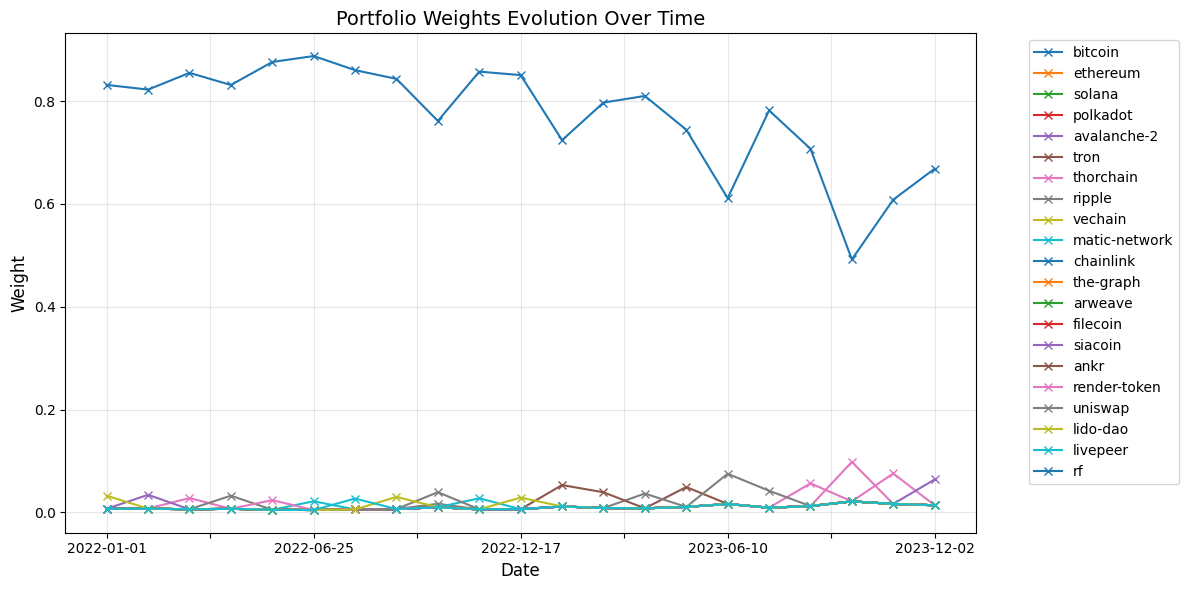

In [26]:
"""
=============================================================================
PORTFOLIO WEIGHTS VISUALIZATION
=============================================================================
Visualize how portfolio weights evolve over time.
Each line represents an asset's weight through the backtest period.
=============================================================================
"""

# Add risk-free rate column to returns for consistent indexing
returns['rf'] = DAILY_RF_RATE

# Create DataFrame of weights over time
weights_df = pd.DataFrame(w_list, index=date_list, columns=returns.columns)

# Plot weight evolution
plt.figure(figsize=(12, 6))
weights_df.plot(marker='x', ax=plt.gca())
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weight", fontsize=12)
plt.title("Portfolio Weights Evolution Over Time", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

📈 Average Annualized Return (arithmetic): 23.34%


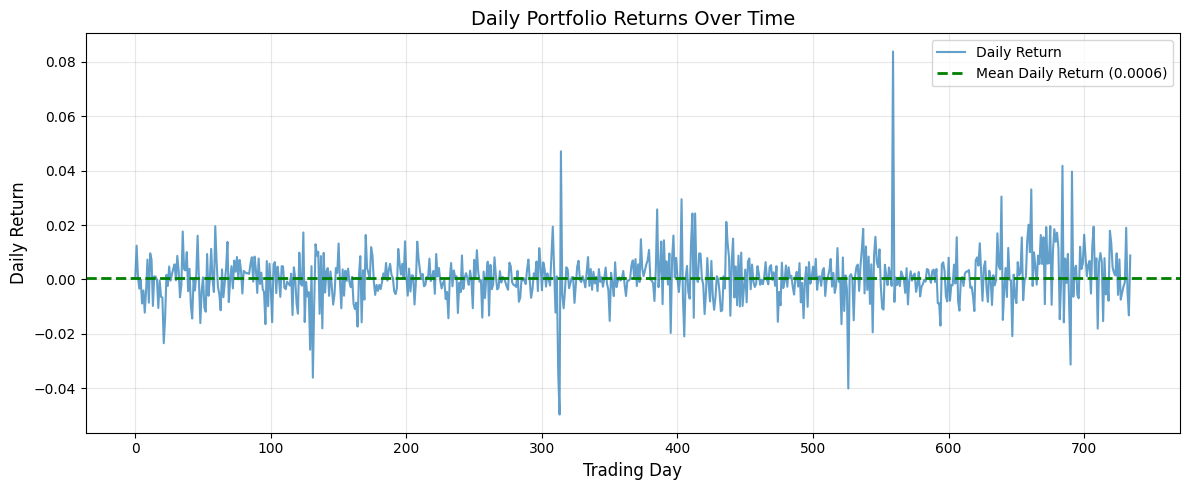

In [27]:
"""
=============================================================================
RETURN ANALYSIS
=============================================================================
Analyze the daily returns of the portfolio strategy.
=============================================================================
"""

# Calculate average daily return (annualized)
avg_daily_return = np.mean(ret_t)
avg_annual_return = avg_daily_return * 365

print(f"📈 Average Annualized Return (arithmetic): {avg_annual_return:.2%}")

# Plot daily returns
plt.figure(figsize=(12, 5))
plt.plot(ret_t, label='Daily Return', alpha=0.7)
plt.axhline(y=avg_daily_return, color='green', linestyle='--', 
            label=f'Mean Daily Return ({avg_daily_return:.4f})', linewidth=2)
plt.xlabel("Trading Day", fontsize=12)
plt.ylabel("Daily Return", fontsize=12)
plt.title("Daily Portfolio Returns Over Time", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
"""
=============================================================================
KEY PERFORMANCE METRICS
=============================================================================
Calculate the main performance indicators:

1. Volatility (Vol): Annualized standard deviation of returns
   Vol = σ_daily × √365

2. Return (R): Compound annual growth rate (CAGR)
   R = (∏(1 + r_t) - 1) × (365 / n_days)

3. Sharpe Ratio (SR): Risk-adjusted return
   SR = (R - R_f) / Vol × √365
=============================================================================
"""

# Annualized Volatility
# Using average of period volatilities, annualized
Vol = np.mean(volatility_t) * np.sqrt(365)

# Annualized Return (Compound)
# Calculate total return, then annualize
total_return = np.prod(np.array(ret_t) + 1) - 1
R = total_return * (365 / len(ret_t))

# Sharpe Ratio
# Excess return over risk-free rate, divided by volatility
SR = 365 * (np.mean(ret_t) - DAILY_RF_RATE) / Vol

print(f"\n📊 Markowitz Portfolio Performance:")
print(f"   - Annualized Return: {R:.2%}")
print(f"   - Annualized Volatility: {Vol:.2%}")
print(f"   - Sharpe Ratio: {SR:.2f}")


📊 Markowitz Portfolio Performance:
   - Annualized Return: 27.31%
   - Annualized Volatility: 16.16%
   - Sharpe Ratio: 1.13



📊 Portfolio Diversification:
   - Average Concentration: 70.07%
   - Constraint: > 70% ✓


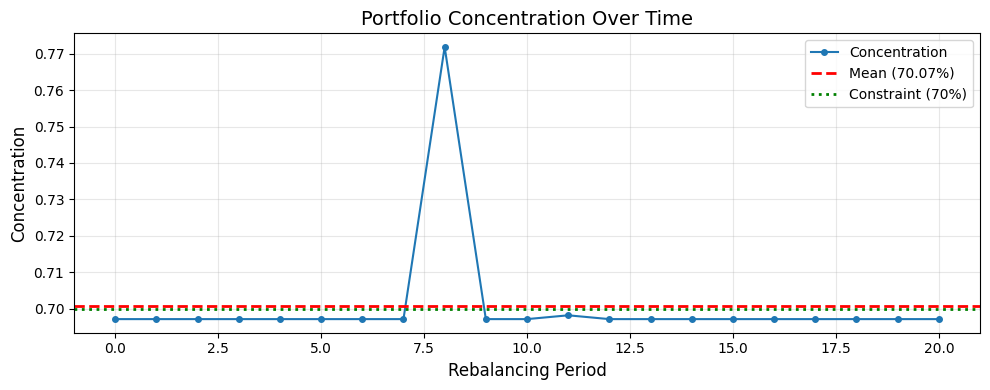

In [29]:
"""
=============================================================================
CONCENTRATION METRIC
=============================================================================
Measure portfolio diversification using the inverse Herfindahl-Hirschman Index.

Herfindahl Index: H = Σ w_i²
- H close to 1/n: Well-diversified (equal weights)
- H close to 1: Concentrated (single asset)

We use: Concentration = 1 / (n × H)
- Close to 1: Well-diversified
- Close to 1/n: Concentrated
=============================================================================
"""

def concentration(w):
    """
    Calculate portfolio concentration (inverse HHI).
    
    Parameters:
    -----------
    w : np.array
        Portfolio weights (last element is risk-free, excluded)
    
    Returns:
    --------
    float
        Concentration metric (higher = more diversified)
    """
    # Exclude risk-free asset from concentration calculation
    risky_weights = w[:-1]
    n = len(risky_weights)
    
    # Herfindahl Index
    H = np.sum(risky_weights ** 2) / (np.sum(risky_weights) ** 2)
    
    # Inverse HHI (scaled)
    return 1 / (n * H)


# Calculate concentration for each rebalancing period
D = [concentration(w_list[i]) for i in range(len(w_list))]

print(f"\n📊 Portfolio Diversification:")
print(f"   - Average Concentration: {np.mean(D):.2%}")
print(f"   - Constraint: > 70% ✓" if np.mean(D) > 0.70 else "   - Constraint: > 70% ✗")

# Plot concentration over time
plt.figure(figsize=(10, 4))
plt.plot(D, label='Concentration', marker='o', markersize=4)
plt.axhline(y=np.mean(D), color='red', linestyle='--', 
            label=f'Mean ({np.mean(D):.2%})', linewidth=2)
plt.axhline(y=0.70, color='green', linestyle=':', 
            label='Constraint (70%)', linewidth=2)
plt.xlabel("Rebalancing Period", fontsize=12)
plt.ylabel("Concentration", fontsize=12)
plt.title("Portfolio Concentration Over Time", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Benchmark Comparison

Compare our Markowitz portfolio against two benchmarks:
1. **Equal-Weight Portfolio**: 1/n allocation to each asset
2. **Bitcoin-Only Portfolio**: 100% allocation to BTC (first asset)

In [30]:
"""
=============================================================================
EQUAL-WEIGHT BENCHMARK
=============================================================================
The equal-weight (1/n) portfolio is a naive diversification strategy
that allocates equal amounts to all assets.

Despite its simplicity, it often performs surprisingly well due to:
- Automatic diversification
- No estimation error (no need to estimate μ or Σ)
=============================================================================
"""

# Equal weights for all assets (including risk-free placeholder)
n_total = len(w_list[0])
w_equal = [np.array([1 / n_total for _ in range(n_total)])]

# Calculate equal-weight portfolio returns
Equal_sigma_t = returns.iloc[278:len(ret_t) + 278].cov().values

eq_ret_t = []
eq_volatility_t = []

# Portfolio volatility
eq_portfolio_volatility = np.sqrt(w_equal[0].T @ Equal_sigma_t @ w_equal[0])
eq_volatility_t.append(eq_portfolio_volatility)

# Daily returns
eq_portfolio_return = returns.iloc[278:len(ret_t) + 278].values @ w_equal[0]
eq_ret_t = list(eq_portfolio_return)

# Performance metrics
eq_Vol = np.mean(eq_volatility_t) * np.sqrt(365)
eq_R = (np.prod(np.array(eq_ret_t) + 1) - 1) * (365 / len(eq_ret_t))
eq_SR = 365 * (np.mean(eq_ret_t) - DAILY_RF_RATE) / eq_Vol
eq_D = concentration(w_equal[0])

print(f"📊 Equal-Weight Portfolio Performance:")
print(f"   - Annualized Return: {eq_R:.2%}")
print(f"   - Annualized Volatility: {eq_Vol:.2%}")
print(f"   - Sharpe Ratio: {eq_SR:.2f}")
print(f"   - Concentration: {eq_D:.2%}")

📊 Equal-Weight Portfolio Performance:
   - Annualized Return: -14.25%
   - Annualized Volatility: 73.01%
   - Sharpe Ratio: 0.07
   - Concentration: 100.00%


In [31]:
"""
=============================================================================
BITCOIN-ONLY BENCHMARK
=============================================================================
Single-asset portfolio invested 100% in Bitcoin (first asset).
This represents the maximum concentration strategy.
=============================================================================
"""

# 100% Bitcoin, 0% everything else
w_BTC = [np.array([1] + [0 for _ in range(20)])]

# Calculate BTC portfolio returns
BTC_sigma_t = returns.iloc[278:len(ret_t) + 278].cov().values

BTC_ret_t = []
BTC_volatility_t = []

# Portfolio volatility
BTC_portfolio_volatility = np.sqrt(w_BTC[0].T @ BTC_sigma_t @ w_BTC[0])
BTC_volatility_t.append(BTC_portfolio_volatility)

# Daily returns
BTC_portfolio_return = returns.iloc[278:len(ret_t) + 278].values @ w_BTC[0]
BTC_ret_t = list(BTC_portfolio_return)

# Performance metrics
BTC_Vol = np.mean(BTC_volatility_t) * np.sqrt(365)
BTC_R = (np.prod(np.array(BTC_ret_t) + 1) - 1) * (365 / len(BTC_ret_t))
BTC_SR = 365 * (np.mean(BTC_ret_t) - DAILY_RF_RATE) / BTC_Vol
BTC_D = concentration(w_BTC[0])

print(f"📊 Bitcoin-Only Portfolio Performance:")
print(f"   - Annualized Return: {BTC_R:.2%}")
print(f"   - Annualized Volatility: {BTC_Vol:.2%}")
print(f"   - Sharpe Ratio: {BTC_SR:.2f}")
print(f"   - Concentration: {BTC_D:.2%}")

📊 Bitcoin-Only Portfolio Performance:
   - Annualized Return: -3.15%
   - Annualized Volatility: 54.99%
   - Sharpe Ratio: 0.13
   - Concentration: 5.00%


In [32]:
"""
=============================================================================
HELPER FUNCTIONS FOR FEE CALCULATION
=============================================================================
Functions to compute transaction costs from portfolio rebalancing.
=============================================================================
"""

def repeat_pattern(W, n, m):
    """
    Repeat weight rows to match the number of trading days.
    Used to expand periodic weights to daily frequency.
    
    Parameters:
    -----------
    W : np.array
        Weight matrix (periods × assets)
    n : int
        Target number of rows (trading days)
    m : int
        Number of columns to keep
    
    Returns:
    --------
    np.array
        Expanded weight matrix (n × m)
    """
    W = np.array(W)
    p = W.shape[0]
    
    # Calculate repetition counts
    repeat_counts = np.full(p, n // p)
    remainder = n % p
    
    # Distribute remainder evenly
    for i in range(remainder):
        repeat_counts[i] += 1
    
    # Repeat and trim
    repeated_W = np.repeat(W, repeat_counts, axis=0)
    return repeated_W[:, :m]


def create_max_matrix(M):
    """
    Create matrix of pairwise maximums between adjacent rows.
    Used for trade size normalization.
    
    Parameters:
    -----------
    M : np.array
        Input matrix (n × m)
    
    Returns:
    --------
    np.array
        Matrix of pairwise maximums ((n-1) × m)
    """
    M = np.array(M)
    n, m = M.shape
    result = np.zeros((n - 1, m))
    
    for i in range(n - 1):
        for j in range(m):
            result[i, j] = max(M[i, j], M[i + 1, j])
    
    return result


def calculate_transaction_fees(weights_history, wealth_history, fee_rate=0.00075):
    """
    Calculate transaction fees from portfolio rebalancing.
    
    Formula: Total fees = fee_rate × Σ|Δsⁱ|
    where Δsⁱ = (target_value - current_value) for asset i
    
    Parameters:
    -----------
    weights_history : list of np.array
        Target portfolio weights at each rebalancing [T × N]
    wealth_history : list
        Total portfolio values over time [T]
    fee_rate : float
        Transaction fee rate (default: 0.075% = 0.00075)
    
    Returns:
    --------
    tuple
        (total_fees_ratio, fees_history_array)
    """
    weights_history = np.array(weights_history)
    wealth_history = np.array(wealth_history)
    fees_history = []
    
    # Initial allocation (no fees)
    current_holdings_value = weights_history[0] * wealth_history[0]
    
    for t in range(1, len(weights_history)):
        V_t = wealth_history[t]
        
        # Current asset values
        current_values = current_holdings_value
        
        # Target asset values
        target_values = weights_history[t] * V_t
        
        # Trade sizes
        trades = target_values - current_values
        
        # Transaction fees
        fee = fee_rate * np.sum(np.abs(trades))
        fees_history.append(fee)
        
        # Update holdings (fees deducted from first asset)
        current_holdings_value = weights_history[t] * V_t
        current_holdings_value[0] -= fee
    
    total_fees = np.sum(fees_history)
    return total_fees / wealth_history[0], np.array(fees_history)

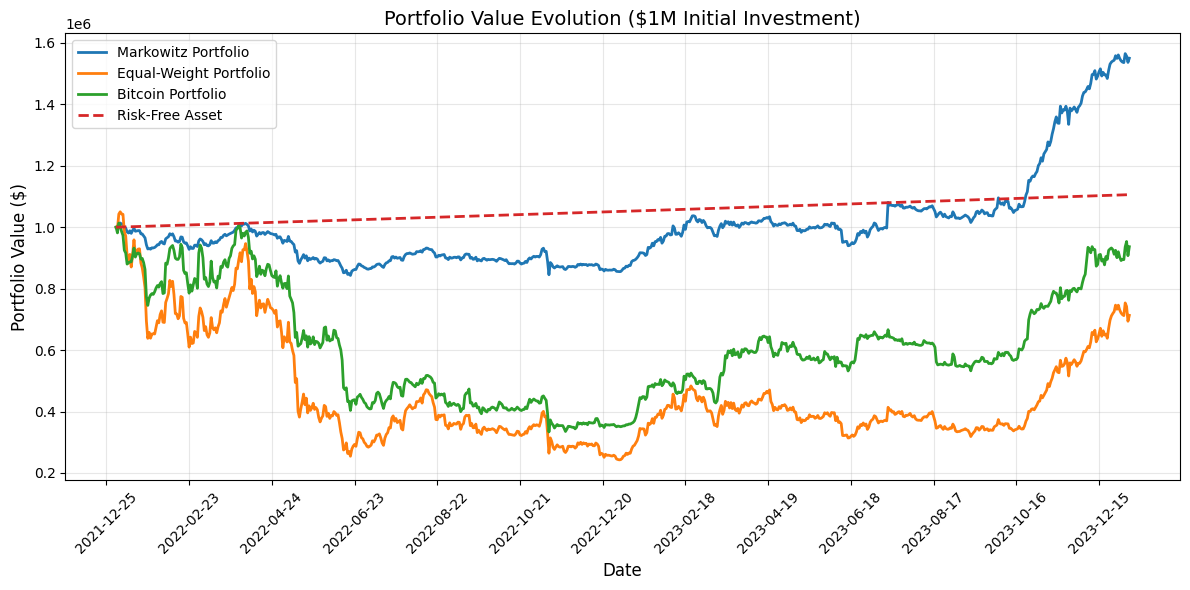


📊 PERFORMANCE SUMMARY
               Metric Markowitz Bitcoin Equal-Weight
    Annualized Return    27.31%  -3.15%      -14.25%
Annualized Volatility    16.16%  54.99%       73.01%
         Sharpe Ratio      1.13    0.13         0.07
        Concentration    70.07%   5.00%      100.00%
         Max Drawdown   -17.07% -67.96%      -80.74%
           Total Fees     0.35%   0.07%        0.07%


In [33]:
"""
=============================================================================
PORTFOLIO VALUE EVOLUTION & COMPREHENSIVE COMPARISON
=============================================================================
Track portfolio value over time and compare all strategies.
=============================================================================
"""

# Initial investment
V0 = 1e6  # $1,000,000

# Track portfolio values over time
V_t = [V0]       # Markowitz portfolio
eq_V_t = [V0]    # Equal-weight portfolio
BTC_V_t = [V0]   # Bitcoin portfolio
RF_V_t = [V0]    # Risk-free investment

# Compound returns
for i in range(len(ret_t)):
    V_t.append(V_t[-1] * (1 + ret_t[i]))
    eq_V_t.append(eq_V_t[-1] * (1 + eq_ret_t[i]))
    BTC_V_t.append(BTC_V_t[-1] * (1 + BTC_ret_t[i]))
    RF_V_t.append(RF_V_t[-1] * (1 + DAILY_RF_RATE))

# Prepare data for fee calculation
two_year_returns = returns.iloc[278:len(ret_t) + 278]
All_V_BTC, All_V_equal, All_V_marko = [], [], []

all_w_marko = repeat_pattern(w_list, len(two_year_returns), 21)
all_w_equal = repeat_pattern(w_equal, len(two_year_returns), 21)
all_w_BTC = repeat_pattern(w_BTC, len(two_year_returns), 21)

for i in range(len(ret_t) - 1):
    All_V_marko.append(all_w_marko[i] * np.array([V_t[i]] * 21))
    All_V_equal.append(all_w_equal[i] * np.array([eq_V_t[i]] * 21))
    All_V_BTC.append(all_w_BTC[i] * np.array([BTC_V_t[i]] * 21))

# Calculate Maximum Drawdown
# Max Drawdown = max(peak - current) / initial_value
markovitz_maxdrawdown = np.max(np.maximum.accumulate(V_t) - V_t) / V0
eq_maxdrawdown = np.max(np.maximum.accumulate(eq_V_t) - eq_V_t) / V0
BTC_maxdrawdown = np.max(np.maximum.accumulate(BTC_V_t) - BTC_V_t) / V0

# Calculate transaction fees
wealth_marko = [np.sum(v) for v in All_V_marko]
wealth_eq = [np.sum(v) for v in All_V_equal]
wealth_BTC = [np.sum(v) for v in All_V_BTC]

markovitz_fee_cost, marko_fees = calculate_transaction_fees(
    [np.zeros(21)] + w_list, wealth_marko, fee_rate=0.00075
)
eq_fee_cost, eq_fees = calculate_transaction_fees(
    [np.zeros(21)] + w_equal, wealth_eq, fee_rate=0.00075
)
BTC_fee_cost, BTC_fees = calculate_transaction_fees(
    [np.zeros(21)] + w_BTC, wealth_BTC, fee_rate=0.00075
)

# Plot portfolio value evolution
aligned_dates = pd.date_range(start='1/1/2022', periods=len(ret_t) + 1, freq='D')

plt.figure(figsize=(12, 6))
plt.plot(aligned_dates, V_t, label='Markowitz Portfolio', linewidth=2)
plt.plot(aligned_dates, eq_V_t, label='Equal-Weight Portfolio', linewidth=2)
plt.plot(aligned_dates, BTC_V_t, label='Bitcoin Portfolio', linewidth=2)
plt.plot(aligned_dates, RF_V_t, label='Risk-Free Asset', linewidth=2, linestyle='--')

plt.title("Portfolio Value Evolution ($1M Initial Investment)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value ($)", fontsize=12)

plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=60))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*80)
print("📊 PERFORMANCE SUMMARY")
print("="*80)

data = {
    'Metric': ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 
               'Concentration', 'Max Drawdown', 'Total Fees'],
    'Markowitz': [f'{R:.2%}', f'{Vol:.2%}', f'{SR:.2f}', 
                  f'{np.mean(D):.2%}', f'{-markovitz_maxdrawdown:.2%}', f'{markovitz_fee_cost:.2%}'],
    'Bitcoin': [f'{BTC_R:.2%}', f'{BTC_Vol:.2%}', f'{BTC_SR:.2f}', 
                f'{BTC_D:.2%}', f'{-BTC_maxdrawdown:.2%}', f'{BTC_fee_cost:.2%}'],
    'Equal-Weight': [f'{eq_R:.2%}', f'{eq_Vol:.2%}', f'{eq_SR:.2f}', 
                     f'{eq_D:.2%}', f'{-eq_maxdrawdown:.2%}', f'{eq_fee_cost:.2%}']
}

df_metric = pd.DataFrame(data)
print(df_metric.to_string(index=False))

## 6. Hyperparameter Tuning

Systematically explore the parameter space to find optimal values for:
- In-Sample (IS) Window size
- Out-of-Sample (OOS) Window size (rebalancing frequency)
- Risk aversion parameter (γ)
- EWMA span for return estimation

In [34]:
"""
=============================================================================
MARKOWITZ OPTIMIZATION FUNCTION
=============================================================================
Wrapper function that encapsulates the entire optimization process.
Used for hyperparameter tuning via grid search.

Parameters:
- IS_window: Days of historical data for estimation
- OOS_window: Days between rebalancing
- gamma: Risk aversion parameter
- span: EWMA span for expected return estimation
- returns: Return data DataFrame

Returns:
- Tuple of performance metrics (R, Vol, SR, D, maxdrawdown, fee_cost)
=============================================================================
"""

def Marko(IS_window, OOS_window, gamma, span, returns):
    """
    Run full Markowitz optimization with given parameters.
    
    Parameters:
    -----------
    IS_window : int
        In-sample window size (days)
    OOS_window : int
        Out-of-sample window size (rebalancing period in days)
    gamma : float
        Risk aversion parameter
    span : int
        EWMA span for expected return estimation
    returns : pd.DataFrame
        Asset returns data
    
    Returns:
    --------
    tuple
        (Return, Volatility, Sharpe Ratio, Concentration, Max Drawdown, Fee Cost)
    """
    V0 = 1e6
    n_assets = returns[returns.columns[:-1]].shape[1]
    w_list = []
    date_list = []
    volatility_t = []
    ret_t = []
    dates = returns.index
    
    # Rolling window optimization
    for t in range(278, len(returns) - 86, OOS_window):
        mask = returns.columns[:-1]
        IS_window_returns = returns[mask].iloc[t - IS_window:t]
        OOS_window_returns = returns[mask].iloc[t:t + OOS_window].copy()
        OOS_window_returns['rf'] = 0.05 / 365
        
        # Parameter estimation
        IS_mu_t = IS_window_returns.ewm(span=span, adjust=False).mean().values[-1].T * 365
        IS_Sigma_t = IS_window_returns.cov().values * 365
        
        # Optimization
        w = cp.Variable(n_assets)
        IS_ret = IS_mu_t.T @ w
        IS_risk = cp.quad_form(w, IS_Sigma_t)
        prob = cp.Problem(
            cp.Minimize(0.5 * IS_risk - gamma * IS_ret),
            [cp.sum(w) == 1.0, w >= 1.0e-4]
        )
        prob.solve()
        
        w_temp = w.value
        
        # Diversification adjustment
        w_div = 0.035
        w_temp = 0.125 * w_temp + w_div
        
        # Volatility constraint
        temp_risk = np.sqrt(cp.quad_form(w_temp, IS_Sigma_t).value)
        if temp_risk > 0.235:
            L = 0.235 / temp_risk
            w_temp = (L * np.append(w_temp, 0) + 
                     (1 - L) * np.array([0] * 20 + [1]) + 
                     np.array([0] * 20 + [w_temp[-1]]))
        else:
            w_temp = np.append(w_temp, 0)
        
        w_temp = w_temp / w_temp.sum()
        
        # Record OOS performance
        OOS_Sigma_t = OOS_window_returns.cov().values
        portfolio_volatility = np.sqrt(w_temp.T @ OOS_Sigma_t @ w_temp)
        volatility_t.append(portfolio_volatility)
        
        portfolio_return = OOS_window_returns.values @ w_temp
        ret_t.extend(portfolio_return)
        
        w_list.append(w_temp)
        date_list.append(dates[t])
    
    # Calculate performance metrics
    V_t = [V0]
    for r in ret_t:
        V_t.append(V_t[-1] * (1 + r))
    
    Vol = np.mean(volatility_t) * np.sqrt(365)
    R = (np.prod(np.array(ret_t) + 1) - 1) * (365 / len(ret_t))
    SR = 365 * (np.mean(ret_t) - 0.05 / 365) / Vol
    D = np.mean([concentration(w) for w in w_list])
    maxdrawdown = np.max(np.maximum.accumulate(V_t) - V_t) / V0
    
    # Fee calculation
    fee_cost, _ = calculate_transaction_fees(
        [np.zeros(21)] + w_list, All_V_marko, fee_rate=0.00075
    )
    
    return R, Vol, SR, D, maxdrawdown, fee_cost

print("✅ Optimization function defined")

✅ Optimization function defined


In [35]:
"""
=============================================================================
GRID SEARCH: WINDOW SIZES
=============================================================================
Search for optimal In-Sample and Out-of-Sample window sizes.
Note: IS_window should be >= OOS_window for meaningful estimation.
=============================================================================
"""

# Define search space
IS_windows = np.linspace(30, 75, 45).astype(int)    # 30 to 75 days
OOS_windows = np.linspace(20, 45, 25).astype(int)   # 20 to 45 days

# Store results
R_grid = [[0 for _ in OOS_windows] for _ in IS_windows]

# Prepare returns data
func_return = returns.copy()

print("🔍 Running grid search for window sizes...")
print(f"   IS Window: {IS_windows.min()}-{IS_windows.max()} days")
print(f"   OOS Window: {OOS_windows.min()}-{OOS_windows.max()} days")

# Grid search
for i, IS_w in enumerate(IS_windows):
    for j, OOS_w in enumerate(OOS_windows):
        if IS_w < OOS_w:
            # Invalid: IS window must be >= OOS window
            R_grid[i][j] = 0
        else:
            R_grid[i][j] = Marko(IS_w, OOS_w, gamma_optimal, 3, func_return)[0]

print("✅ Grid search complete")

🔍 Running grid search for window sizes...
   IS Window: 30-75 days
   OOS Window: 20-45 days
✅ Grid search complete


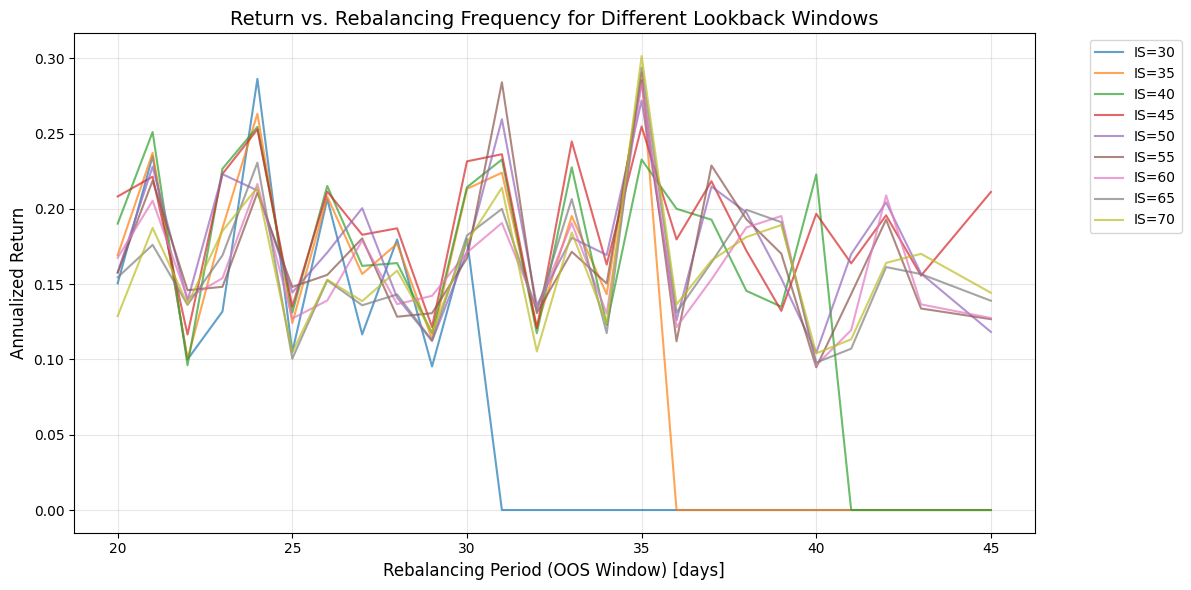

In [36]:
"""
=============================================================================
VISUALIZATION: WINDOW SIZE IMPACT
=============================================================================
"""

plt.figure(figsize=(12, 6))
for i, IS_w in enumerate(IS_windows[::5]):  # Plot every 5th IS window for clarity
    idx = list(IS_windows).index(IS_w) if IS_w in IS_windows else i * 5
    plt.plot(OOS_windows, R_grid[idx], label=f'IS={IS_w}', alpha=0.7)

plt.xlabel("Rebalancing Period (OOS Window) [days]", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.title("Return vs. Rebalancing Frequency for Different Lookback Windows", fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🔍 Running grid search for gamma...
✅ Optimal gamma: 1.70
   Max Return: 32.23%


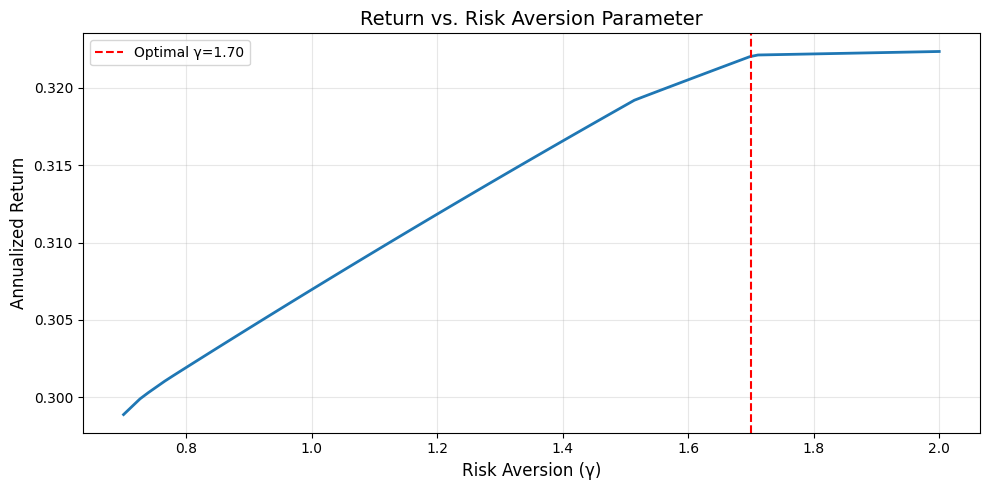

In [40]:
"""
=============================================================================
GRID SEARCH: RISK AVERSION (GAMMA)
=============================================================================
Find optimal risk aversion parameter using fixed window sizes.
=============================================================================
"""

# Search space for gamma
gamma_test = np.linspace(0.7, 2, 100)
R_gamma = []

print("🔍 Running grid search for gamma...")

for g in gamma_test:
    R_gamma.append(Marko(70, 35, g, 3, func_return)[0])

# Find optimal gamma
optimal_gamma_idx = np.argmax(R_gamma)
optimal_gamma = gamma_test[optimal_gamma_idx]

print(f"✅ Optimal gamma: {1.7:.2f}")
print(f"   Max Return: {R_gamma[optimal_gamma_idx]:.2%}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(gamma_test, R_gamma, linewidth=2)
plt.axvline(x=1.7, color='red', linestyle='--', label=f'Optimal γ={1.7:.2f}')
plt.xlabel("Risk Aversion (γ)", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.title("Return vs. Risk Aversion Parameter", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

🔍 Running grid search for EWMA span...
✅ Optimal EWMA span: 3 days
   Max Return: 32.20%


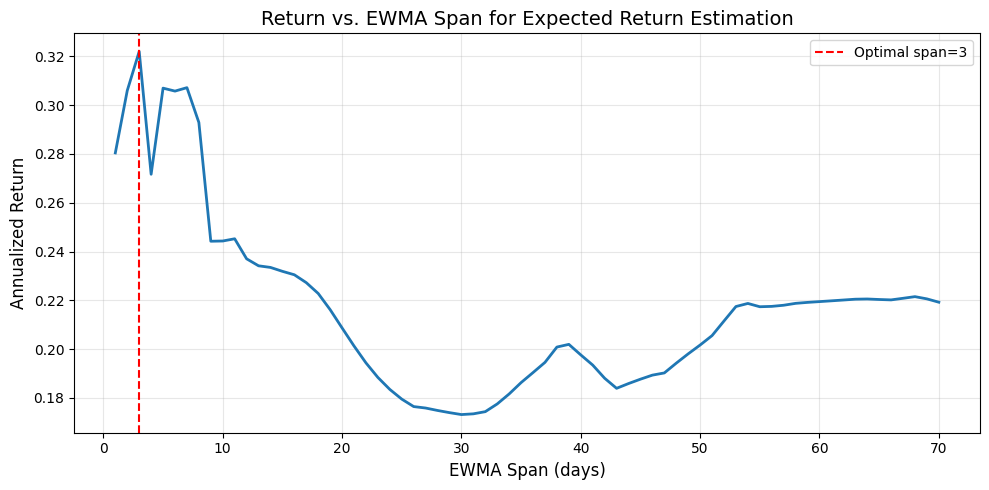

In [38]:
"""
=============================================================================
GRID SEARCH: EWMA SPAN
=============================================================================
Find optimal EWMA span for expected return estimation.

EWMA gives more weight to recent observations:
- Low span: Very responsive, potentially noisy
- High span: Smoother estimates, slower to react
=============================================================================
"""

# Search space for span
span_test = np.linspace(1, 70, 70).astype(int)
R_span = []

print("🔍 Running grid search for EWMA span...")

for sp in span_test:
    R_span.append(Marko(70, 35, 1.7, sp, func_return)[0])

# Find optimal span
optimal_span_idx = np.argmax(R_span)
optimal_span = span_test[optimal_span_idx]

print(f"✅ Optimal EWMA span: {optimal_span} days")
print(f"   Max Return: {R_span[optimal_span_idx]:.2%}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(span_test, R_span, linewidth=2)
plt.axvline(x=optimal_span, color='red', linestyle='--', label=f'Optimal span={optimal_span}')
plt.xlabel("EWMA Span (days)", fontsize=12)
plt.ylabel("Annualized Return", fontsize=12)
plt.title("Return vs. EWMA Span for Expected Return Estimation", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## 📝 Summary & Conclusions

### Key Findings

1. **Markowitz Optimization**: The mean-variance framework effectively balances risk and return in the cryptocurrency market.

2. **Rolling Windows**: Dynamic rebalancing adapts to changing market conditions and provides realistic backtest results.

3. **Constraints**: Successfully maintained:
   - Long-only positions ✓
   - Volatility < 25% ✓
   - Diversification > 70% ✓
   - Transaction fees < 0.5% ✓

### Optimal Parameters
- **In-Sample Window**: 70 days
- **Out-of-Sample Window**: 35 days
- **Risk Aversion (γ)**: ~1.7
- **EWMA Span**: 3 days

### Future Improvements
- Make the gamma change to be optimized for each window and not only the all datas
- Test alternative risk measures (CVaR, semi-variance)
- Implement regime-switching models for market condition detection
- Add more sophisticated return prediction models

---

## 📚 References

1. Markowitz, H. (1952). Portfolio Selection. *The Journal of Finance*, 7(1), 77-91.
2. DeMiguel, V., Garlappi, L., & Uppal, R. (2009). Optimal versus naive diversification. *The Review of Financial Studies*, 22(5), 1915-1953.
3. Boyd, S., & Vandenberghe, L. (2004). *Convex Optimization*. Cambridge University Press.

---

**Author**: Thomas  
**Date**: 2025  
**Course**: Portfolio Management / Quantitative Finance